In [2]:
using LinearAlgebra, Plots, SparseArrays
using PolynomialRoots

In [3]:
# gives the coefficients to the 2*kth derivative for 2*r+1 point formalism.
function get_coeff_2kth_derviative(r,k=1)
    A = [2*i^(2*j)//factorial(2*j) for i=1:r, j=1:r]
    B = hcat(rotr90(Matrix(1I, r, r)), [-2 for i=1:r], Matrix(1I, r, r))
    coeff = inv(A)*B
    return Rational.(coeff[k,r+1:end])
end

# generate the matrix K from given potential
# Ψ_{n+1} = K * Ψ_n
function get_time_evolution_matrix(potential_vals; r=2, z_s = -2, Δt=Δt, Δx=Δx, mass=mass, ħ=ħ)

    b = (im * ħ * Δt) / (2 * mass * (Δx)^2)
    cn_coeffs = get_coeff_2kth_derviative(r)
    a_ks = (b / z_s) * cn_coeffs
    spatial_samples = length(potential_vals)
    d_js = (1 + a_ks[begin]) * ones(spatial_samples) - potential_vals * (im * Δt / ħ) / z_s


    I = [i for i = 1:spatial_samples]
    J = [j for j = 1:spatial_samples]
    S = d_js
    for k = 1:r
        upper_tri_i = [i for i = 1:spatial_samples-k]
        upper_tri_j = [i + k for i = 1:spatial_samples-k]

        I = vcat(I, upper_tri_i, upper_tri_j)
        J = vcat(J, upper_tri_j, upper_tri_i)

        S = vcat(S, a_ks[k+1] * ones(2 * (spatial_samples - k)))
    end

    A1 = Matrix(sparse(I, J, S))

    return inv(A1) * conj.(A1)
end

get_time_evolution_matrix (generic function with 1 method)

In [4]:
## table of cn coefficients
for i = 1:5
    println("r = $i", " ⇢ ", get_coeff_2kth_derviative(i))
end

r = 1 ⇢ 

Rational{Int64}[-2//1, 1//1]
r = 2 ⇢ Rational{Int64}[-5//2, 4//3, -1//12]
r = 3 ⇢ Rational{Int64}[-49//18, 3//2, -3//20, 1//90]
r = 4 ⇢ Rational{Int64}[-205//72, 8//5, -1//5, 8//315, -1//560]
r = 5 ⇢ Rational{Int64}[-5269//1800, 5//3, -5//21, 5//126, -5//1008, 1//3150]


┌ Info: Saved animation to /tmp/jl_m54VWf0bEZ.gif
└ @ Plots /home/paras/.julia/packages/Plots/nuwp4/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_m54VWf0bEZ.gif")
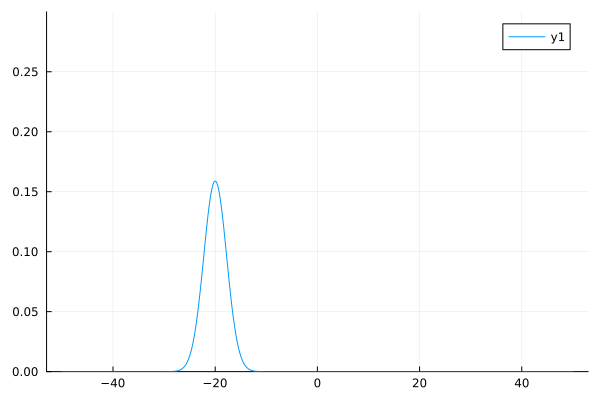

In [5]:
ħ = 1
mass = 1/2

Δt = 0.1
Δx = 0.1

x_vals = -50:Δx:50
t_vals = 0:Δt:50

# Initialize and evolve the wavefunction
Ψ_vals = (x -> exp(-(x+20)^2/10 - im*5/ħ*x)).(x_vals)
Ψ_vals = Ψ_vals / sqrt(sum(Ψ_vals .* conj.(Ψ_vals)))

# infinite potential well
function potential_well(x)
    if abs(x) < 40
        return 0
    else
        return 1E3
    end
end

# potential_vals = (x -> x).(x_vals)
potential_vals = (x -> potential_well(x)).(x_vals)
Ψ_grid = copy(Ψ_vals)

K = get_time_evolution_matrix(potential_vals; r=3, Δt=Δt, Δx=Δx, mass=mass, ħ=ħ)

for t_i in 2:length(t_vals)
    Ψ_grid = hcat(Ψ_grid, K * Ψ_grid[:,t_i-1])
end

@gif for t_i in 1:length(t_vals)
    plot(x_vals,abs.(Ψ_grid[:,t_i]))
    ylims!(0,0.3)
end

In [6]:
sum(Ψ_grid.*conj.(Ψ_grid), dims=1)

1×501 Matrix{ComplexF64}:
 1.0+0.0im  1.0+0.0im  1.0+0.0im  …  1.0+0.0im  1.0+0.0im  1.0+0.0im

## Pade Approximants

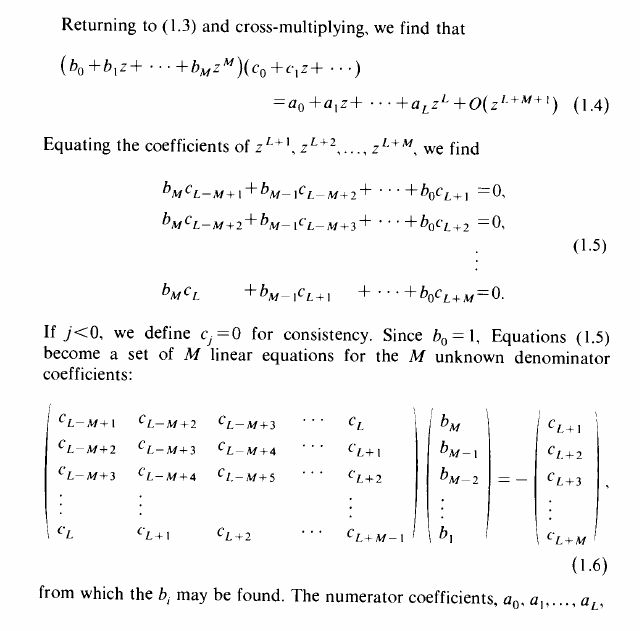

In [7]:
function pade_coeffs_exp(M)
    C = [1//factorial(i+j-1) for i in 1:M, j in 1:M]
    C_right = -[1//factorial(i+M) for i in 1:M]
    coeff = inv(C)*C_right
    b_rev = vcat(coeff,1)
    b = reverse(b_rev)    

    a = []
    s = +1
    for b_ in b
        a = vcat(a, s*b_)
        s = -s
    end

    return Rational.(a), b

end

function roots_pade_exp(M)
    a, b = pade_coeffs_exp(M)
    return roots(a), roots(b)
end

roots_pade_exp (generic function with 1 method)

In [12]:
## Table for Pade Roots
for i = 1:5
    a_roots, b_roots = roots_pade_exp(i)
    println("M = ", i, " ⇢ ", round.(a_roots, digits = 2))
    #println("M = ", i, " -> ", round.(b_roots, digits = 2))
end

M = 1 ⇢ ComplexF64[-2.0 + 0.0im]
M = 2 ⇢ ComplexF64[-3.0 - 1.73im, -3.0 + 1.73im]
M = 3 ⇢ ComplexF64[-3.68 - 3.51im, -4.64 + 0.0im, -3.68 + 3.51im]
M = 4 ⇢ ComplexF64[-4.21 - 5.31im, -5.79 - 1.73im, -5.79 + 1.73im, -4.21 + 5.31im]
M = 5 ⇢ ComplexF64[-4.65 + 7.14im, -7.29 + 0.0im, -6.7 - 3.49im, -4.65 - 7.14im, -6.7 + 3.49im]


In [9]:
function get_pade_time_evolution_matrix(potential_vals; M=1, r = 3, Δt=Δt, Δx=Δx, mass=mass, ħ=ħ)
    K = 1I
    a_roots,_ = roots_pade_exp(M)
    for s in 1:M
        Ks = get_time_evolution_matrix(potential_vals; r=r, z_s = a_roots[s], Δt=Δt, Δx=Δx, mass=mass, ħ=ħ)
        K = K*Ks
    end
    return K
end

get_pade_time_evolution_matrix (generic function with 1 method)

┌ Info: Saved animation to /tmp/jl_Y5Ur6HqzM3.gif
└ @ Plots /home/paras/.julia/packages/Plots/nuwp4/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_Y5Ur6HqzM3.gif")
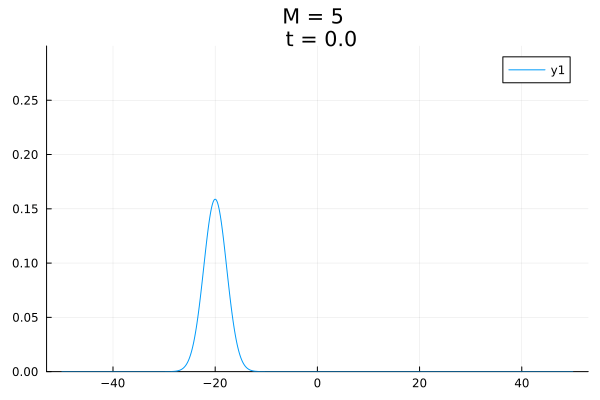

In [20]:
potential_vals = (x -> 0).(x_vals)
Ψ_grid = copy(Ψ_vals)

M = 5
r = 3
K = get_pade_time_evolution_matrix(potential_vals; M=M, r=r, Δt=Δt, Δx=Δx, mass=mass, ħ=ħ)

for t_i in 2:length(t_vals)
    Ψ_grid = hcat(Ψ_grid, K * Ψ_grid[:,t_i-1])
end

@gif for t_i in 1:length(t_vals)
    plot(x_vals,abs.(Ψ_grid[:,t_i]))
    ylims!(0,0.3)
    title!("M = $M \n t = $(round(t_vals[t_i], digits = 2))")
end
    

In [16]:
sum(Ψ_grid.*conj.(Ψ_grid), dims=1)

1×501 Matrix{ComplexF64}:
 1.0+0.0im  1.0+0.0im  1.0+0.0im  …  1.0+0.0im  1.0+0.0im  1.0+0.0im